In [2]:
#@title
import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.model_selection as model_selection


In [3]:
import os

In [4]:
os.getcwd()

'/Users/ML/Desktop/bootcamp/DL/projekt DL'

# podlaczamy dysk google
from google.colab import drive
drive.mount('/content/drive')

In [5]:
banana_path = "/Users/ML/Desktop/bootcamp/DL/projekt DL/owoce do projektu/Banana"
orange_path = "/Users/ML/Desktop/bootcamp/DL/projekt DL/owoce do projektu/Orange"
pitaya_path = "/Users/ML/Desktop/bootcamp/DL/projekt DL/owoce do projektu/Pitaya"

In [6]:
import os
import shutil
from PIL import Image
from keras.preprocessing import image

In [7]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [8]:
input_shape = (224, 224, 3)
batch_size = 256
X = []
y = []
# Wczytanie obrazków bananów
for file in os.listdir(banana_path):
    img = load_img(os.path.join(banana_path, file), target_size=input_shape[:2])
    img = img_to_array(img) / 255.0
    X.append(img)
    y.append('banana')  
# Wczytanie obrazków pomarańczy
for file in os.listdir(orange_path):
    img = load_img(os.path.join(orange_path, file), target_size=input_shape[:2])
    img = img_to_array(img) / 255.0
    X.append(img)
    y.append('orange')    
# Wczytanie obrazków pitaya
for file in os.listdir(pitaya_path):
    img = load_img(os.path.join(pitaya_path, file), target_size=input_shape[:2])
    img = img_to_array(img) / 255.0
    X.append(img)
    y.append('pitaya')   
X = np.array(X)
y = np.array(y)

In [9]:
X.shape

(8540, 224, 224, 3)

In [10]:
type(y)

numpy.ndarray

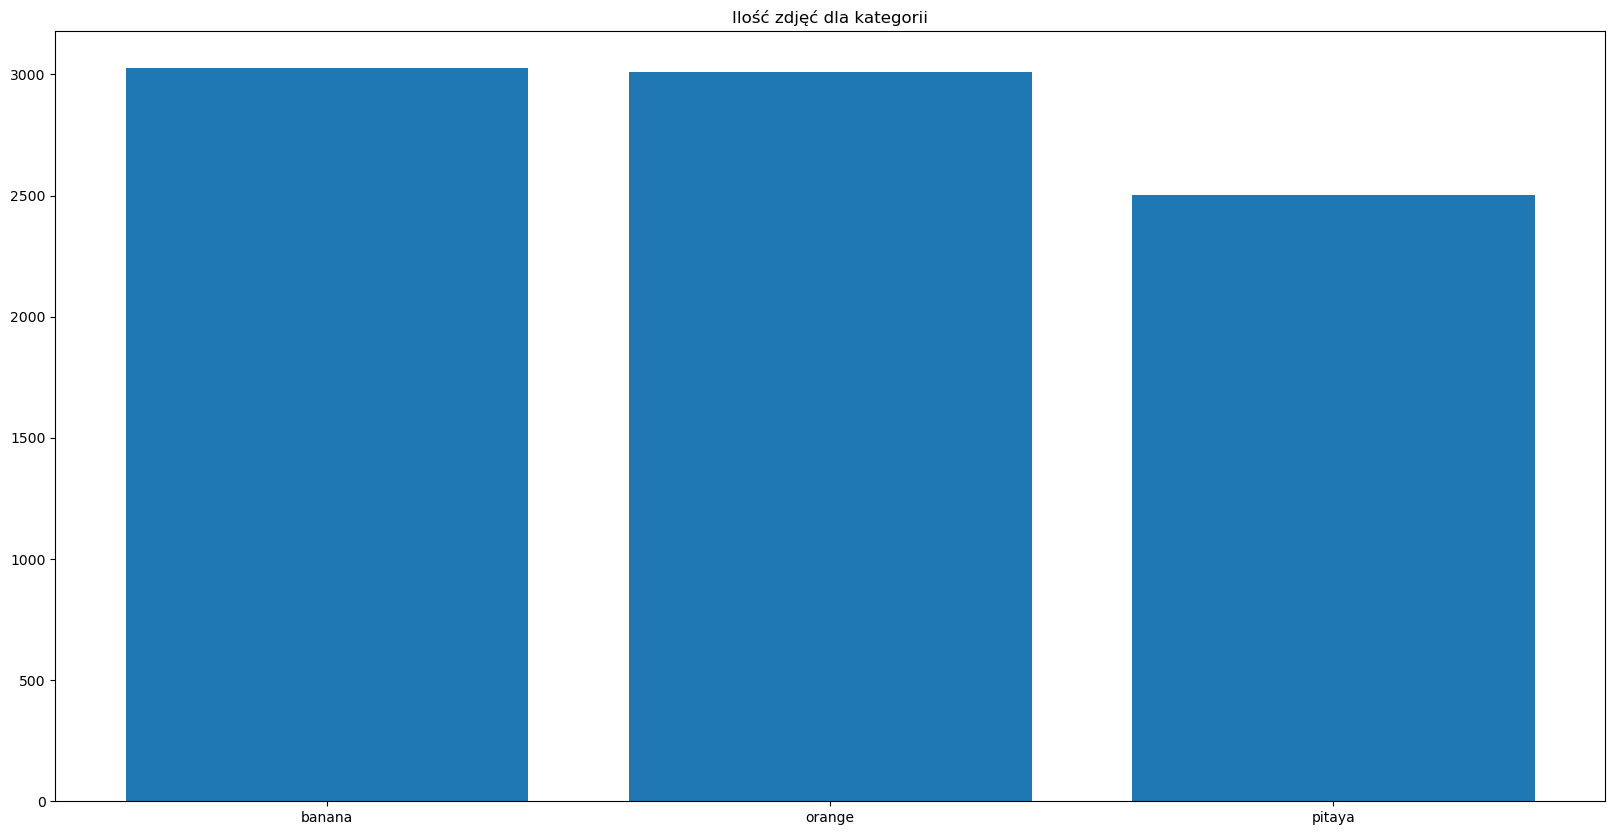

In [11]:
# policzenia ile jest próbek z każdej klasy
uniques, counts = np.unique(y, return_counts=True)
# wyświetlenie ilości na wykresie
fig = plt.figure(figsize = (20,10))
plt.bar(uniques, counts)
plt.title('Ilość zdjęć dla kategorii')
plt.show()

In [12]:
np.array(np.unique(y, return_counts=True)).T

array([['banana', '3027'],
       ['orange', '3012'],
       ['pitaya', '2501']], dtype='<U21')

pitaya


<Figure size 640x480 with 0 Axes>

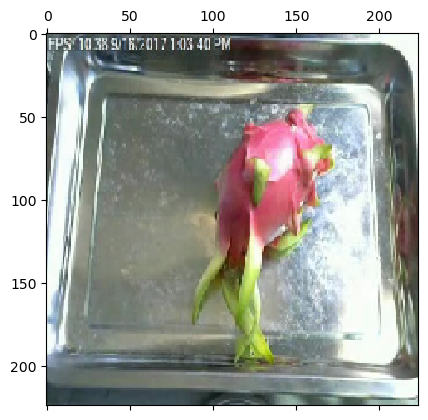

In [13]:
# pobierzmy przykladowy obrazek
n = 8000
plt.gray()
plt.matshow(X[n])
print (y[n])



In [14]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=123)

In [15]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
# transformujemy y_test
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
# podglądamy
y_test = y_test.astype(np.float32)

# transformujemy y_train
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
# podglądamy
y_train = y_train.astype(np.float32)

In [18]:
x_train.shape

(6832, 224, 224, 3)

In [19]:
y_train.shape

(6832, 3)

In [20]:
inputLayer = tf.keras.Input(shape=(input_shape))

In [21]:
# bierzemy wytrenowany wcześniej model
base_model = tf.keras.applications.ResNet101V2(
    weights='imagenet',  # wczytaj z nauczonymi wagami
    input_shape=input_shape,
    include_top=False)   # nie dołączaj ostatniej warstwy klasyfikatora, sami swoją dodamy

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [22]:
base_model.trainable = False

In [23]:
x = base_model(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(3, activation='softmax')(x)

In [24]:
# zamykamy w kerasowy model
model = tf.keras.Model(inputLayer, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 42,632,707
Trainable params: 6,147
Non-trainable params: 42,626,560
_____________________________________________

In [25]:
# obiekt do zapisywania przebiegów testowych i referencyjnych
# uzupelnij na podstawie przykładu podanego w treści zadania :)
file_writer_preds = tf.summary.create_file_writer(os.path.join(log_dir, "preds"))
file_writer_ref = tf.summary.create_file_writer(os.path.join(log_dir, "ref"))

NameError: name 'log_dir' is not defined

In [26]:
# funkcja zapisująca wyniki pracy modelu do pliku
def log_model_predictions(logs):
    history = model_1.history

    y_pred = model_1.predict(x_seq_test)

    model_1.history = history
    
    # Log predictions
    for i in range(y_pred.shape[0]):
        # uzupelnij na podstawie przykładu podanego w treści zadania :)
        # pamiętaj, że y_pred będzie miał kształt (n_probek, 1)
        with file_writer_preds.as_default():
            tf.summary.scalar('act_vs_pred', y_pred[i][0], step=i)
        with file_writer_ref.as_default():
            tf.summary.scalar('act_vs_pred', y_test[i][0], step=i)

In [27]:
# dodajemy zapisywanie logów do tensorboard'a
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# callback od wcześniejszego zakończenia treningu
patience = 4
es_callback = keras.callbacks.EarlyStopping(patience=patience)

pred_callback = tf.keras.callbacks.LambdaCallback(on_train_end=log_model_predictions)

In [28]:
%load_ext tensorboard


In [29]:
%tensorboard --logdir logs/datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [30]:
# kompilujemy całość
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [31]:
# trening z podaniem callbacków
history =model.fit(x=x_train,
    y=y_train,
    batch_size=200,
    epochs=20,
    validation_split=0.05,
    callbacks=[
        tensorboard_callback,
        es_callback
    ]
)

Epoch 1/20


2023-07-22 09:06:13.587722: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 124s 4s/step - loss: 0.2550 - accuracy: 0.9052 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 2/20
33/33 [==============================] - 126s 4s/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 3/20
33/33 [==============================] - 135s 4s/step - loss: 0.0095 - accuracy: 0.9985 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 4/20
33/33 [==============================] - 137s 4s/step - loss: 0.0076 - accuracy: 0.9988 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 5/20
33/33 [==============================] - 134s 4s/step - loss: 0.0070 - accuracy: 0.9988 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 6/20
33/33 [==============================] - 136s 4s/step - loss: 0.0045 - accuracy: 0.9995 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 7/20
33/33 [==============================] - 133s 4s/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 8/20
33/33 [======

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

1/1 [==============================] - 2s 2s/step
Wyjścia po treningu 10 epok:
[2 2 1 1 1]

Referencyjne wyjścia:
[2 2 1 1 1]


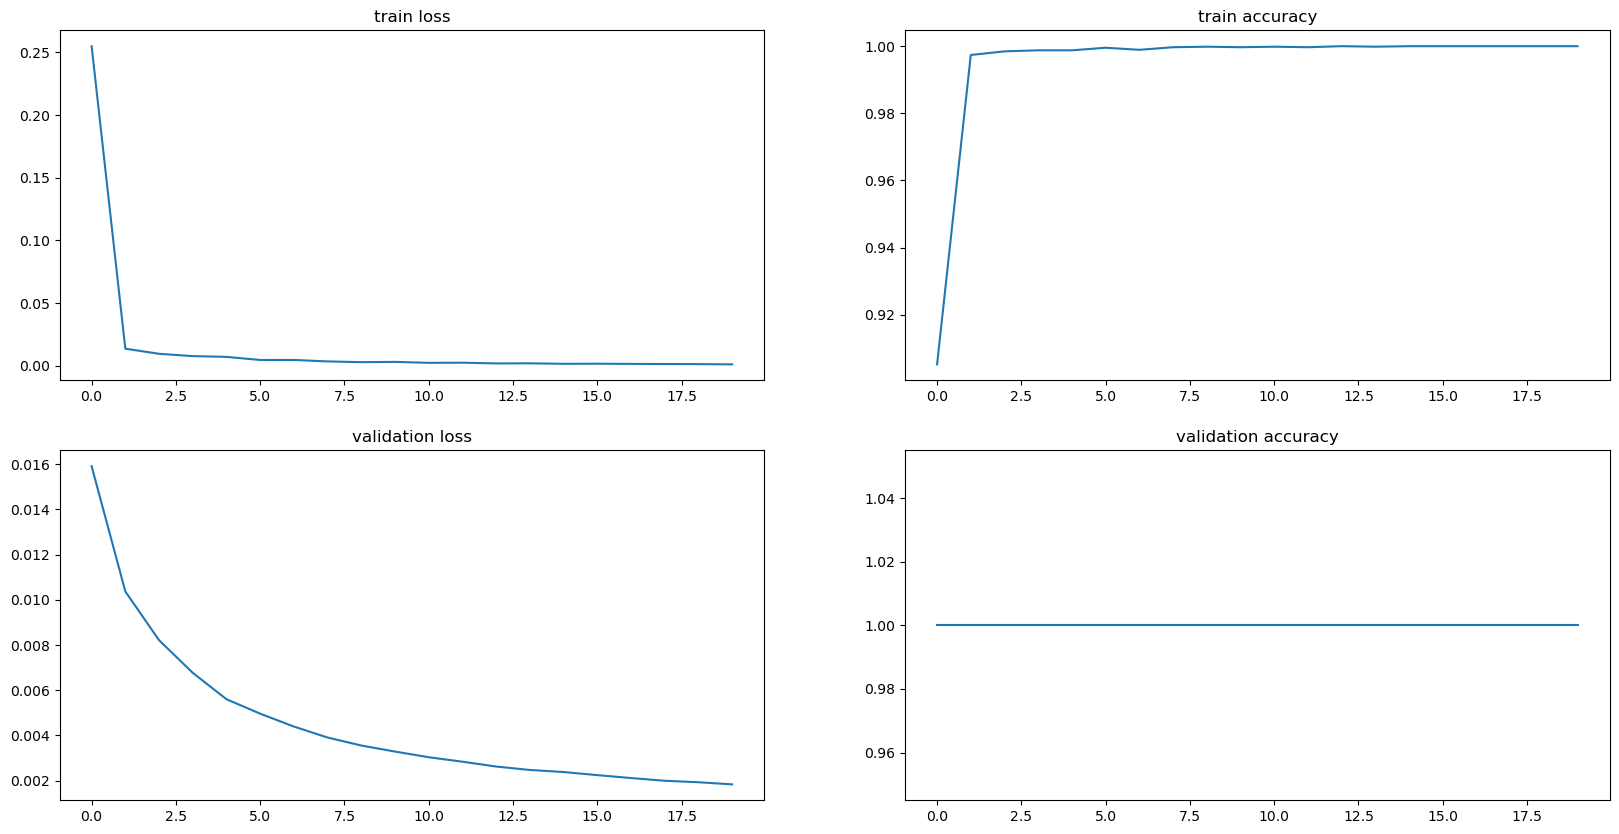

54/54 [==============================] - 30s 542ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599
           1       1.00      1.00      1.00       599
           2       1.00      1.00      1.00       510

    accuracy                           1.00      1708
   macro avg       1.00      1.00      1.00      1708
weighted avg       1.00      1.00      1.00      1708

[[599   0   0]
 [  1 598   0]
 [  0   0 510]]


In [33]:
print("Wyjścia po treningu {0} epok:\n{1}\n\nReferencyjne wyjścia:\n{2}".format(
    10, 
    model.predict(x_test[:5]).argmax(axis=1), 
    y_test[:5].argmax(axis=1)))

# wykresy porównujące jakość modelu na treningu i walidacji
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

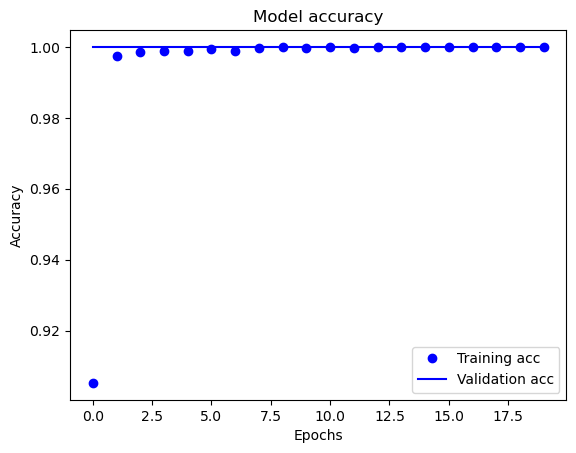

In [44]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(acc, "bo", label="Training acc")
plt.plot(val_acc, "b", label="Validation acc")
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

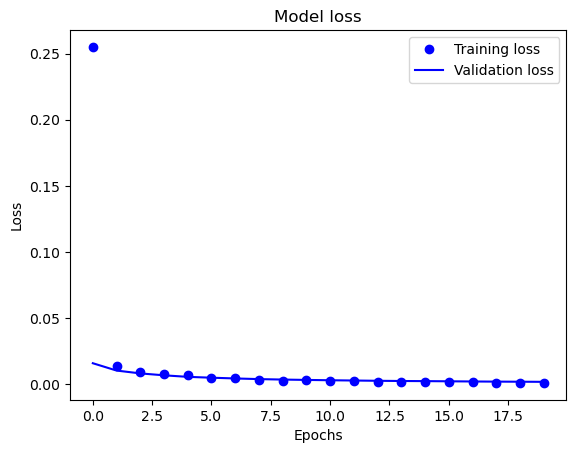

In [45]:
plt.clf()
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss, "bo", label="Training loss")
plt.plot(val_loss, "b", label="Validation loss")
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

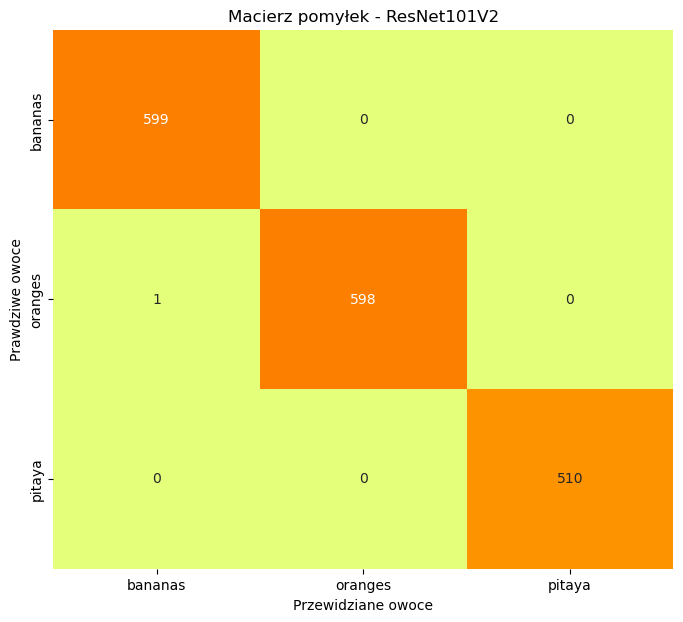

In [62]:
# Obliczanie macierzy pomyłek dla modelu Sieć
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Wyświetlanie macierzy pomyłek
plt.figure(figsize=(8,7))
sns.heatmap(cm, annot=True, cmap='Wistia', fmt='d', cbar=False , xticklabels=['bananas', 'oranges', 'pitaya'], yticklabels=['bananas', 'oranges', 'pitaya'] )
plt.labels = ['bananas', 'oranges', 'pitaya']
plt.xlabel('Przewidziane owoce')
plt.ylabel('Prawdziwe owoce')
plt.title('Macierz pomyłek - ResNet101V2')
plt.show()

In [63]:
model.save('model2.h5')

In [3]:
model = keras.models.load_model('model2.h5')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [65]:
model.predict(X)

267/267 [==============================] - 151s 554ms/step


array([[9.9995565e-01, 4.4148957e-05, 2.8146809e-07],
       [9.9999988e-01, 1.2262707e-07, 6.0789818e-09],
       [9.9999702e-01, 4.9052957e-08, 2.9957378e-06],
       ...,
       [4.7856867e-01, 3.7551671e-01, 1.4591458e-01],
       [4.7856867e-01, 3.7551671e-01, 1.4591458e-01],
       [4.7856867e-01, 3.7551671e-01, 1.4591458e-01]], dtype=float32)

1/1 [==============================] - 2s 2s/step


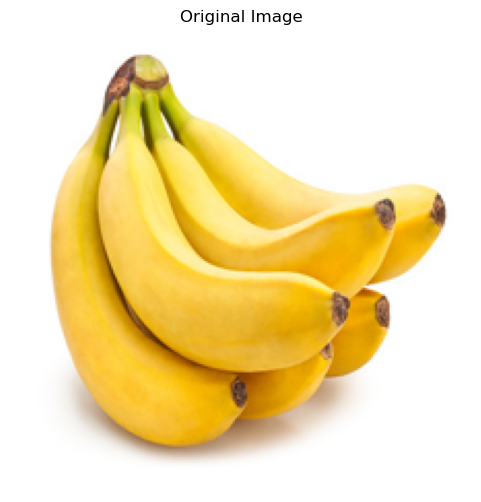

Predicted class: bananas
Confidence score: 0.9999757
1/1 [==============================] - 0s 220ms/step


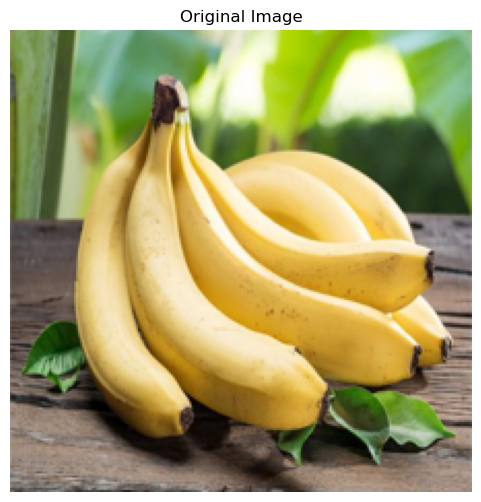

Predicted class: bananas
Confidence score: 0.99994063
1/1 [==============================] - 0s 399ms/step


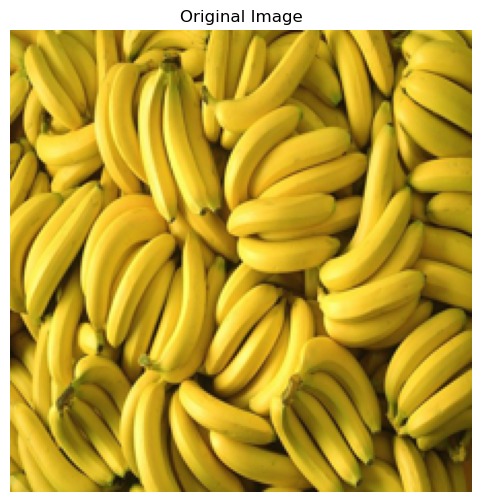

Predicted class: bananas
Confidence score: 0.9987606
1/1 [==============================] - 0s 40ms/step


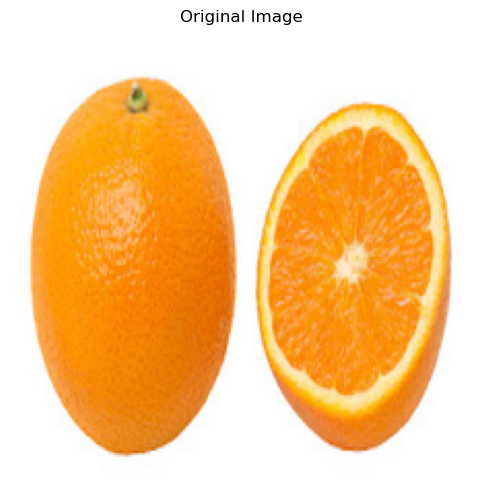

Predicted class: oranges
Confidence score: 0.97353065
1/1 [==============================] - 0s 54ms/step


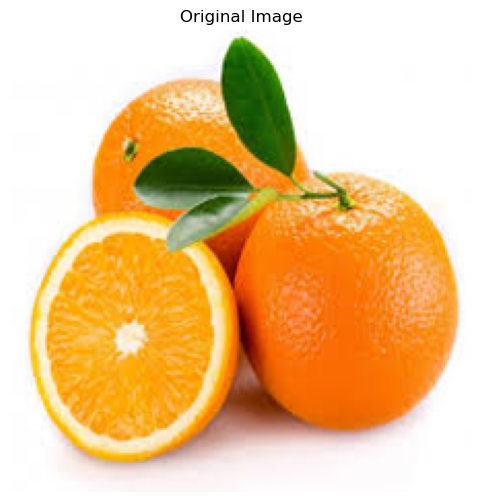

Predicted class: oranges
Confidence score: 0.97243935
1/1 [==============================] - 0s 46ms/step


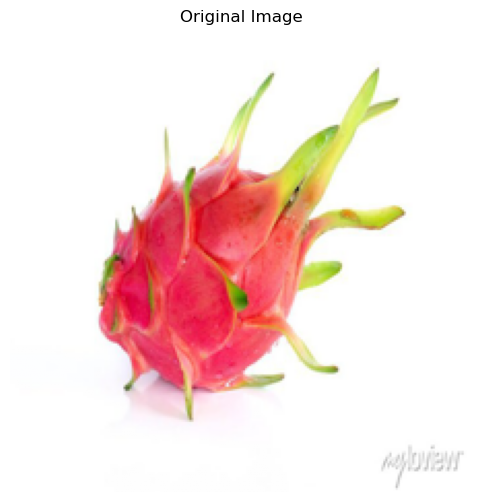

Predicted class: pitaya
Confidence score: 0.9407612
1/1 [==============================] - 0s 41ms/step


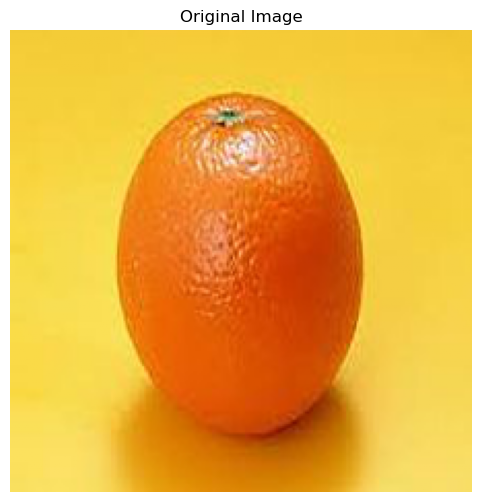

Predicted class: oranges
Confidence score: 0.9992907
1/1 [==============================] - 0s 45ms/step


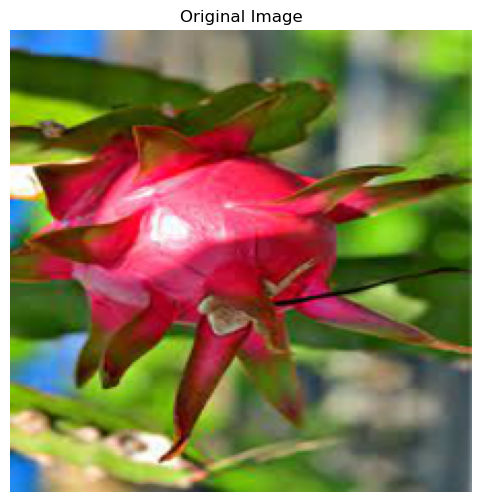

Predicted class: pitaya
Confidence score: 0.9974497
1/1 [==============================] - 0s 48ms/step


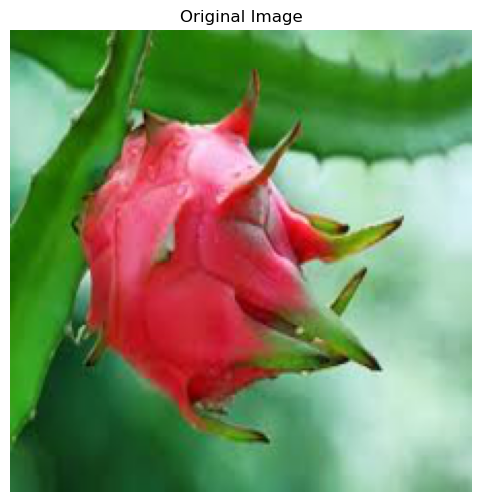

Predicted class: bananas
Confidence score: 0.73073167


In [66]:
# Ścieżka do folderu ze zdjęciami
folder_path = "/Users/ML/Desktop/bootcamp/DL/projekt DL/owoce do projektu/Testowanie"
input_size = (224, 224) 

# Pętla do przetwarzania zdjęć
for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    image = Image.open( os.path.join(folder_path, filename))
    image = image.resize(input_size)
    image = np.array(image)
    image = image / 255.0  # Normalize the image

    # Reshape the image to match the model's input shape
    input_image = np.expand_dims(image, axis=0)

    # Make predictions on the input image
    predictions = model.predict(input_image)
    predicted_class = np.argmax(predictions)

    # Define the class labels
    class_labels = ['bananas', 'oranges', 'pitaya']  # Adjust the class labels according to your model's output

    # Show the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Show the predicted class and confidence score
    predicted_label = class_labels[predicted_class]
    confidence = predictions[0][predicted_class]
    print('Predicted class:', predicted_label)
    print('Confidence score:', confidence)

2023-07-22 14:29:11.422625: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 2s 2s/step


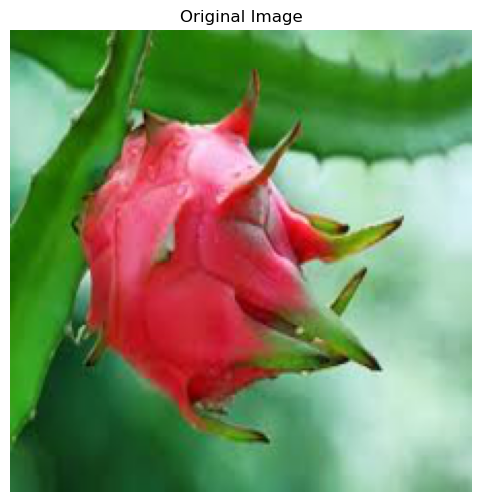

Predicted class: bananas
Confidence score: 0.73073167


In [4]:
# Ścieżka do folderu ze zdjęciami
folder_path = "/Users/ML/Desktop/bootcamp/DL/projekt DL/owoce do projektu/Dodatek"
input_size = (224, 224) 

# Pętla do przetwarzania zdjęć
for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    image = Image.open( os.path.join(folder_path, filename))
    image = image.resize(input_size)
    image = np.array(image)
    image = image / 255.0  # Normalize the image

    # Reshape the image to match the model's input shape
    input_image = np.expand_dims(image, axis=0)

    # Make predictions on the input image
    predictions = model.predict(input_image)
    predicted_class = np.argmax(predictions)

    # Define the class labels
    class_labels = ['bananas', 'oranges', 'pitaya']  # Adjust the class labels according to your model's output

    # Show the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Show the predicted class and confidence score
    predicted_label = class_labels[predicted_class]
    confidence = predictions[0][predicted_class]
    print('Predicted class:', predicted_label)
    print('Confidence score:', confidence)
    
    

In [44]:
a = predictions.reshape(-1,1)

(3, 1)

In [46]:
b = class_labels

In [52]:
polaczona_tablica = np.hstack((np.array(b).reshape(-1, 1),a))

In [55]:
polaczona_tablica

array([['bananas', '0.73073167'],
       ['oranges', '0.00023197563'],
       ['pitaya', '0.26903635']], dtype='<U32')

In [53]:
polaczona_tablica 

array([['bananas', '0.73073167'],
       ['oranges', '0.00023197563'],
       ['pitaya', '0.26903635']], dtype='<U32')

In [98]:
df=pd.DataFrame(polaczona_tablica)
df.columns = ['Predicted Class', 'Confidence score']
df
    

,Predicted Class,Confidence score
0,bananas,0.73073167
1,oranges,0.00023197563
2,pitaya,0.26903635
